In [4]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from groq import Groq
from dotenv import load_dotenv
import os

load_dotenv('/Users/kiara/Documents/matkassen-etl-pipeline/.env')
client = Groq(api_key=os.getenv("GROQ_API_KEY"))

conn = sqlite3.connect('/Users/kiara/Documents/matkassen-etl-pipeline/matkassen-etl/notebook/matkassen.db')
df = pd.read_sql('SELECT * FROM matkassen_tvattad', conn)
conn.close()

df_sentiment = df[df['omdöme_text'].notna()].copy()
print(f"Antal omdömen att analysera: {len(df_sentiment)}")
df_sentiment['omdöme_text'].head(5)

Antal omdömen att analysera: 1117


1            Älskar att slippa planera middagar. Tack!
2    Svamprisotto var verkligen inte gott. Slängde ...
3           Priset är högt men sparar tid. På gränsen.
4        Fungerar, men recepten börjar bli repetitiva.
9                 Snabb leverans och allt var fräscht.
Name: omdöme_text, dtype: object

In [2]:
def analysera_sentiment_batch(texter):
    numrerade = "\n".join([f"{i+1}. {t}" for i, t in enumerate(texter)])
    try:
        response = client.chat.completions.create(
            model="llama-3.3-70b-versatile",
            messages=[
                {"role": "system", "content": "Du är en sentimentanalysmodell. Du får en numrerad lista med omdömen. Svara med ENDAST en numrerad lista med ett ord per rad: Positiv, Neutral eller Negativ."},
                {"role": "user", "content": f"Klassificera dessa omdömen:\n{numrerade}"}
            ],
            max_tokens=500
        )
        svar = response.choices[0].message.content.strip().split("\n")
        resultat = []
        for rad in svar:
            rad = rad.strip()
            if "Positiv" in rad:
                resultat.append("Positiv")
            elif "Negativ" in rad:
                resultat.append("Negativ")
            else:
                resultat.append("Neutral")
        while len(resultat) < len(texter):
            resultat.append("Neutral")
        return resultat[:len(texter)]
    except Exception as e:
        print(f"Fel: {e}")
        return ["Neutral"] * len(texter)

batch_size = 50
sentiments = []
texter = df_sentiment['omdöme_text'].tolist()

for i in range(0, len(texter), batch_size):
    batch = texter[i:i+batch_size]
    resultat = analysera_sentiment_batch(batch)
    sentiments.extend(resultat)
    print(f"✅ Analyserat {min(i+batch_size, len(texter))}/{len(texter)}")

df_sentiment['sentiment'] = sentiments
print("\nKlart!")
print(df_sentiment['sentiment'].value_counts())

✅ Analyserat 50/1117
✅ Analyserat 100/1117
✅ Analyserat 150/1117
✅ Analyserat 200/1117
✅ Analyserat 250/1117
✅ Analyserat 300/1117
✅ Analyserat 350/1117
✅ Analyserat 400/1117
✅ Analyserat 450/1117
✅ Analyserat 500/1117
✅ Analyserat 550/1117
✅ Analyserat 600/1117
✅ Analyserat 650/1117
✅ Analyserat 700/1117
✅ Analyserat 750/1117
✅ Analyserat 800/1117
✅ Analyserat 850/1117
✅ Analyserat 900/1117
✅ Analyserat 950/1117
✅ Analyserat 1000/1117
✅ Analyserat 1050/1117
✅ Analyserat 1100/1117
✅ Analyserat 1117/1117

Klart!
sentiment
Positiv    600
Negativ    259
Neutral    258
Name: count, dtype: int64


✅ Sparad: sentiment_analys.png


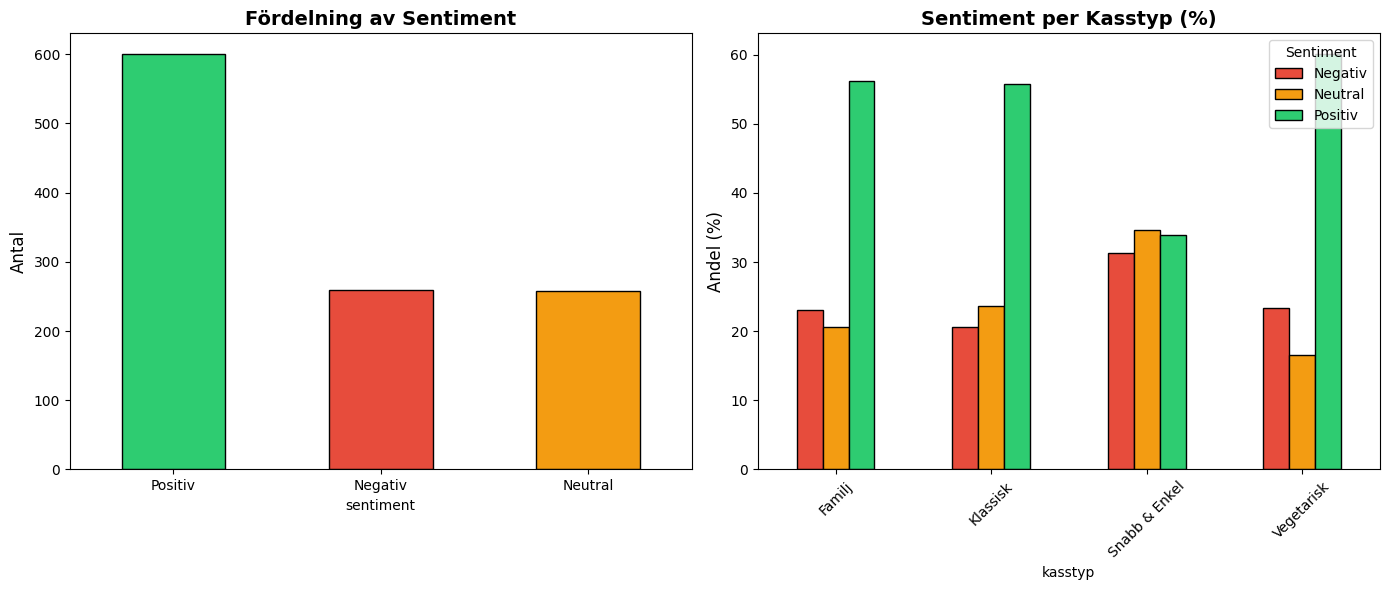

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sentiment_counts = df_sentiment['sentiment'].value_counts()
colors_list = {'Positiv': '#2ecc71', 'Neutral': '#f39c12', 'Negativ': '#e74c3c'}

sentiment_counts.plot(kind='bar', ax=axes[0],
                      color=[colors_list.get(x, 'gray') for x in sentiment_counts.index],
                      edgecolor='black')
axes[0].set_title('Fördelning av Sentiment', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Antal', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)

sentiment_kass = pd.crosstab(df_sentiment['kasstyp'], df_sentiment['sentiment'], normalize='index') * 100
sentiment_kass.plot(kind='bar', ax=axes[1],
                    color=[colors_list.get(x, 'gray') for x in sentiment_kass.columns],
                    edgecolor='black')
axes[1].set_title('Sentiment per Kasstyp (%)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Andel (%)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Sentiment')

plt.tight_layout()
plt.savefig('sentiment_analys.png', dpi=300, bbox_inches='tight')
print("✅ Sparad: sentiment_analys.png")
plt.show()